# Problème P1b : modèle de panache

Ce notebook résout le problème P1b vu en TD. Il implémente un modèle de panache sous la forme d'une classe. Le travail se focalise ici sur l'estimation d'incertitudes.

## Import de modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Définition de la classe

In [2]:
class Model:
    """
    Puff model.
    """

    def __init__(self, nmembers = 1):
        self.nmembers = nmembers  # number of members in the ensemble
        self.dt = 0.05     # in days
        self.iso2 = 0       # index of SO2 in conc vector
        self.iso4 = 1       # index of H2SO4
        self.conc = np.zeros((2,self.nmembers))  # np.zeros(2)
        self.conc[self.iso2,:] = 20.
        self.kso2 = 1./2.
        self.kso4 = 1./5.
        self.position = np.zeros(self.nmembers)
        self.wind = 5.*86.400 * np.ones(self.nmembers)  #  km/j
        if self.nmembers > 1:
            self.wind += np.random.normal(0., 0.25, self.nmembers)*86.400  # Convention : +- 2*sigma
            self.conc[self.iso2,:] += np.random.normal(0., 2.5, self.nmembers)        

        self.conc_series = []
        self.position_series = []
        
    def rhs(self, XC):
        """compute the right hand side term of the differential equation of the puff model."""
        XCout = np.zeros_like(XC)
        XCout[self.iso2] = - self.kso2*XC[self.iso2]
        XCout[self.iso4] = self.kso2*XC[self.iso2] - self.kso4*XC[self.iso4]
        return XCout
        
    def run(self, days):
        """runs the puff model. Takes the number of days as argument.
        Are computed the tracer concentration and the puff position, and their time series."""
        nsteps = int(days/self.dt)
        self.conc_series = np.zeros((2, nsteps+1, self.nmembers))
        self.conc_series[:,0,:] = self.conc    
        self.position_series = np.zeros((nsteps+1, self.nmembers))
        self.position_series[0,:] = self.position
        for it in range(nsteps):
            k1 = self.rhs(self.conc) * self.dt
            xtmp = self.conc + 0.5 * k1
            k2 = self.rhs(xtmp) * self.dt
            xtmp = self.conc + 0.5 * k2
            k3 = self.rhs(xtmp) * self.dt
            xtmp = self.conc + k2
            k4 = self.rhs(xtmp) * self.dt
            self.conc += (k1+2*k2+2*k3+k4)/6.
            self.position += self.wind * self.dt
            self.conc_series[:,it+1,:] = self.conc
            self.position_series[it+1,:] = self.position
            
    def maximum_of_so4(self):
        """Compute the maximum concentration of SO4. return puff position and maximum concentration."""
        posmax = np.zeros(self.nmembers)
        concmax = np.zeros(self.nmembers)
        for ie in range(self.nmembers):
            indmax = np.argmax(self.conc_series[self.iso4,:,ie])
            posmax[ie] = self.position_series[indmax, ie]
            concmax[ie] = self.conc_series[self.iso4, indmax, ie]
        return posmax, concmax 
            
    def plot_simulation(self):
        """Plot results."""
        plt.figure()
        for ie in range(self.nmembers):
            plt.plot(self.position_series[:,ie],self.conc_series[0,:,ie],'black',linewidth=1.)
            plt.plot(self.position_series[:,ie],self.conc_series[1,:,ie],'red',linewidth=1.)
        plt.show()

    def probability_of_detection(self, detection_position, detection_conc):
        """Compute the probability of detection of SO4 at some location.
        Arguments are detection location and detection threshold."""
        a = 1
        # function to write at the end
        

## Une simulation sur 10 jours

La courbe noire pour le SO2, la rouge pour le sulfate : concentrations en fonction de la position du panache.

In [3]:
toto = Model()
toto.run(10)
toto.plot_simulation()

### Localisation et caractérisation du maximum de sulfate

In [4]:
position_max, concentration_max = toto.maximum_of_so4()
print((position_max, concentration_max))

(array([1317.6]), array([10.85766729]))


# Questions


## 1. Représentation et quantification d'incertitudes

1. Il y a des incertitudes sur le vent et sur la concentration initiale : V = $5 \pm 0.5$ m.s$^{-1}$ ; C0 = $20 \pm 5$. Quelle est l'incertitude resultante sur la position du maximum de sulfate ?
2. Un detecteur de sulfate est installe a 1400 km de la zone d emission et donne l'alarme lorsque la concentration depasse 12. Quelle est la probabilité de declenchement ?
3. Des mesures montrent que le max de sulfate se trouve à $1280 \pm 40$ km de la zone d emission. Que peut-on en deduire pour V et C0 ? 

### 1. Incertitude sur la position du maximum de sulfate

Pour répondre à cette question on réalise un ensemble de simulations avec la fonctionnalité introduite dans la classe ci-dessus. Puis on calcule la position du maximum de sulfate pour chacune des simulations. On peut représenter l'histogramme, calculer la moyenne et l'écart-type de l'estimation.

#### Definition de l'instance de classe et examen du vent

On définit la classe et on trace l'histogramme du vent, pour se donner une idée.

In [6]:
Nmem = 1000
ens_toto = Model(nmembers=Nmem)
plt.hist(ens_toto.wind,bins=20)

(array([  1.,   2.,   4.,  16.,  15.,  26.,  50.,  51.,  93., 128., 126.,
        114., 111., 100.,  64.,  50.,  34.,  10.,   2.,   3.]),
 array([355.79253762, 362.84047669, 369.88841576, 376.93635483,
        383.98429389, 391.03223296, 398.08017203, 405.1281111 ,
        412.17605017, 419.22398924, 426.27192831, 433.31986737,
        440.36780644, 447.41574551, 454.46368458, 461.51162365,
        468.55956272, 475.60750179, 482.65544085, 489.70337992,
        496.75131899]),
 <BarContainer object of 20 artists>)

#### Simulation

Puis on réalise l'ensemble de simulations et on trace, comme précédemment.

In [7]:
ens_toto.run(10)
ens_toto.plot_simulation()

#### Maximum de sulfate

On trace l'histogramme des positions de maximum, ce qui donne une idée de l'incertitude sur cette position. Enfin, on calcule la moyenne et l'écart-type de cette position.

(array([  1.,   2.,   4.,  16.,  15.,  26.,  50.,  51.,  93., 128., 126.,
        114., 111., 100.,  64.,  50.,  34.,  10.,   2.,   3.]),
 array([1085.16723974, 1106.6634539 , 1128.15966806, 1149.65588222,
        1171.15209638, 1192.64831054, 1214.14452469, 1235.64073885,
        1257.13695301, 1278.63316717, 1300.12938133, 1321.62559549,
        1343.12180965, 1364.61802381, 1386.11423797, 1407.61045213,
        1429.10666629, 1450.60288044, 1472.0990946 , 1493.59530876,
        1515.09152292]),
 <BarContainer object of 20 artists>)

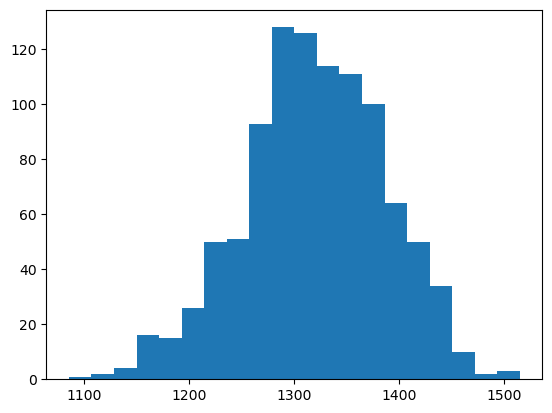

In [8]:
pos, conc = ens_toto.maximum_of_so4()
plt.hist(pos,bins=20)

In [9]:
m, s = np.mean(pos), np.std(pos)
print('La position est :',m,' km + ou - ', s)

La position est : 1319.3301670174496  km + ou -  67.09445990600373


### 2. Probabilité de déclenchement du détecteur

L'idée ici est de compter le nombre de simulations dépassant un seuil de concentration lorsque le panache se trouve à l'endroit du détecteur. C'est la fonction ```probability_of_detection```.

### 3. Exploiter des mesures pour réduire l'incertitude sur le vent